In [1]:
%matplotlib inline
import softmax_chains_replay

In [2]:
CONFIG = {
    'SEED': None,
    
    'N_CHAINS': 9,
    'CHAIN_LENGTH': 4,
    'GAIN': 7,
    'LINGERING_INPUT_VALUE': 1,
    
    'DRIVE_NODE_COORDINATES': [
            [(chain_idx, chain_pos) for chain_pos in range(4)]
            for chain_idx in range(6)
        ],
    'DRIVE_AMPLITUDE': 3,
    
    'N_TRIALS': 6,
    
    'FIG_SIZE': (15, 8),
    'COLORS': [(0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 1, 1), (1, 0, 1), (.5, .5, 0), (.5, .5, .5), (.5, 0, 0)],
    'LW': 2,
    'FONT_SIZE': 16,
}

/Users/rkp/Dropbox/Repositories/be_more_spontaneous/network.py:449: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self.rs == None:
/Users/rkp/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1644: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


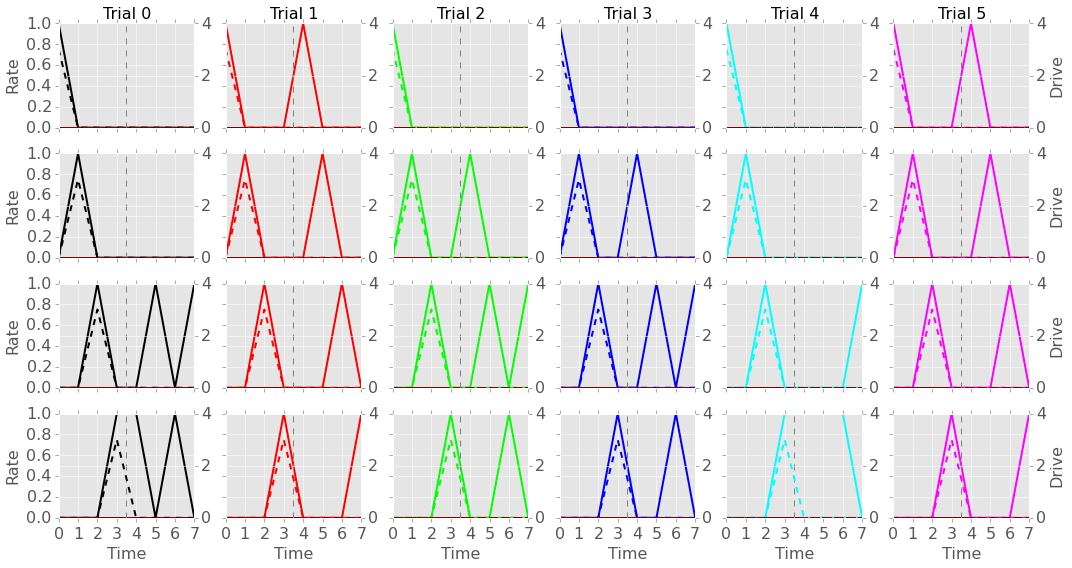

In [3]:
softmax_chains_replay.replay(CONFIG)

In [4]:
CONFIG['DRIVE_NODE_COORDINATES'] = [
    [(0, chain_pos) if chain_pos != 2 else (1, chain_pos) for chain_pos in range(4)]
    for _ in range(6)
]

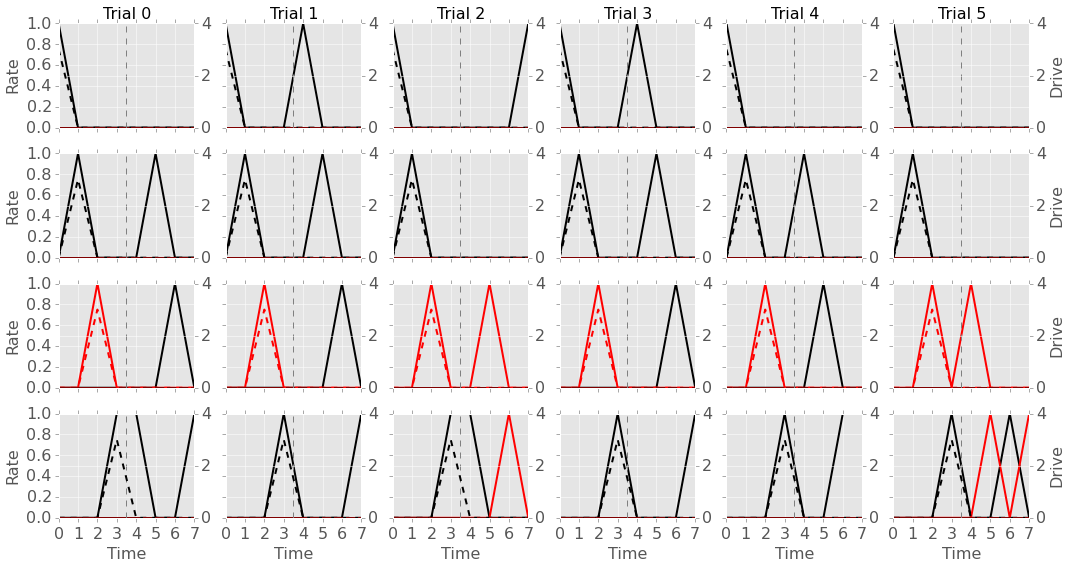

In [5]:
softmax_chains_replay.replay(CONFIG)

In [6]:
CONFIG['DRIVE_NODE_COORDINATES'] = [
    [(0, chain_pos) if chain_pos < 2 else (1, chain_pos) for chain_pos in range(4)]
    for _ in range(6)
]

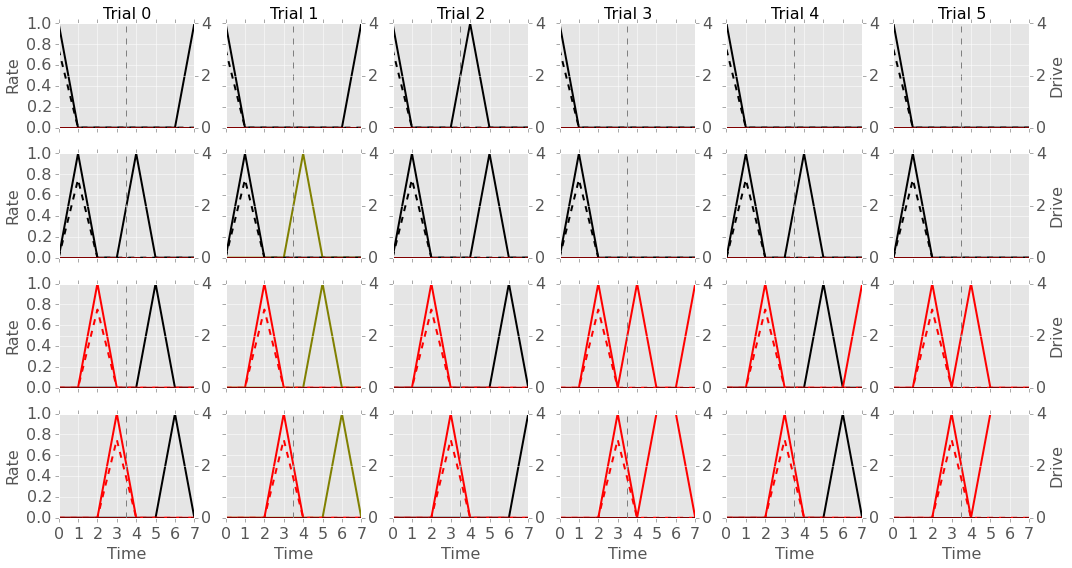

In [7]:
softmax_chains_replay.replay(CONFIG)

In [8]:
CONFIG['DRIVE_NODE_COORDINATES'] = [
    [(chain_idx, chain_pos) if chain_pos != 2 else ((chain_idx + 1)%6, chain_pos) for chain_pos in range(4)]
    for chain_idx in range(6)
]
CONFIG['DRIVE_AMPLITUDE'] = 1

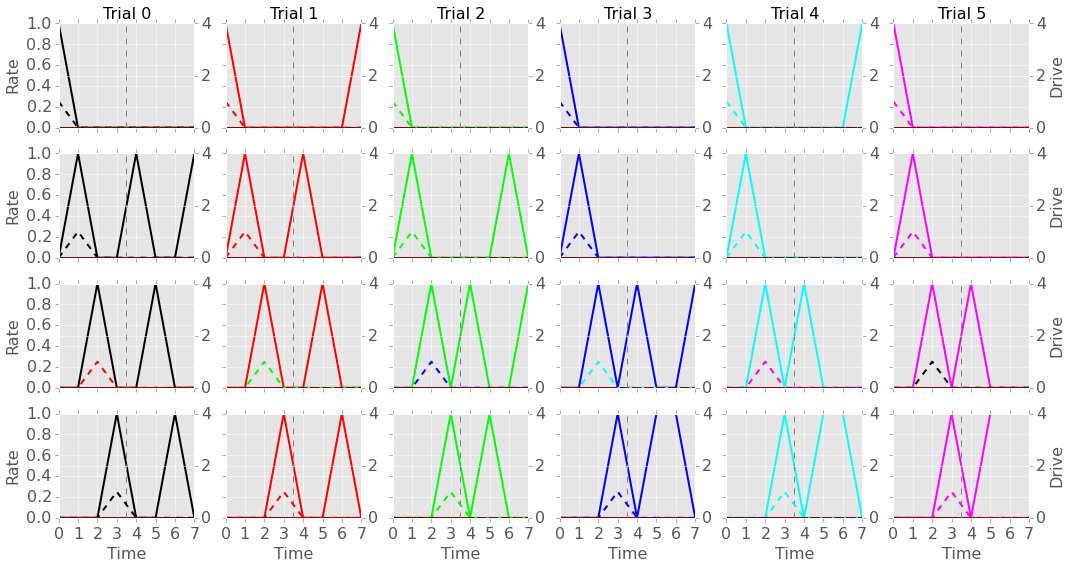

In [9]:
softmax_chains_replay.replay(CONFIG)

In [17]:
CONFIG['WEAK_CXN_IDXS'] = (1, 2)
CONFIG['WEAK_CXN_WEIGHT'] = 1
CONFIG['DRIVE_BY_COORDINATE'] = [
    [((0, chain_pos), 3) if chain_pos < 2 else ((1, chain_pos), 3) for chain_pos in range(4)] + 
    [((0, 0), 0), ((0, 0), 0), ((0, 0), 0), ((0, 0), 0)]
    for _ in range(6)
]

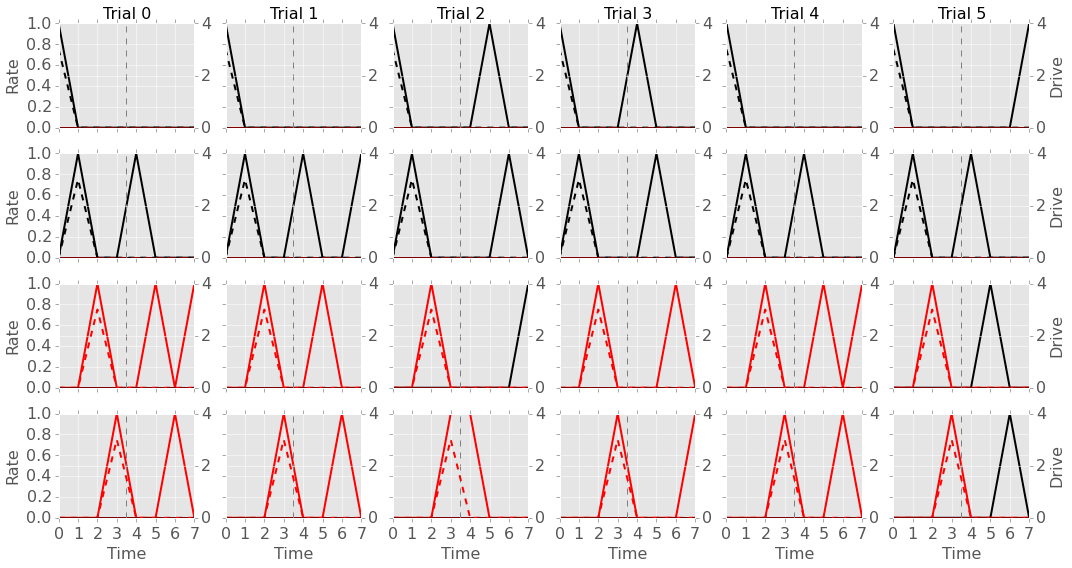

In [19]:
softmax_chains_replay.replay_weak_cxns_added(CONFIG)

In [20]:
CONFIG['N_TRIALS'] = 9
CONFIG['WEAK_CXN_IDXS'] = (1, 2)
CONFIG['WEAK_CXN_WEIGHT'] = 1
CONFIG['DRIVE_BY_COORDINATE'] = [
    [((0, 0), 3), ((0, 0), 0), ((0, 0), 0), ((0, 0), 0)]
    for _ in range(9)
]

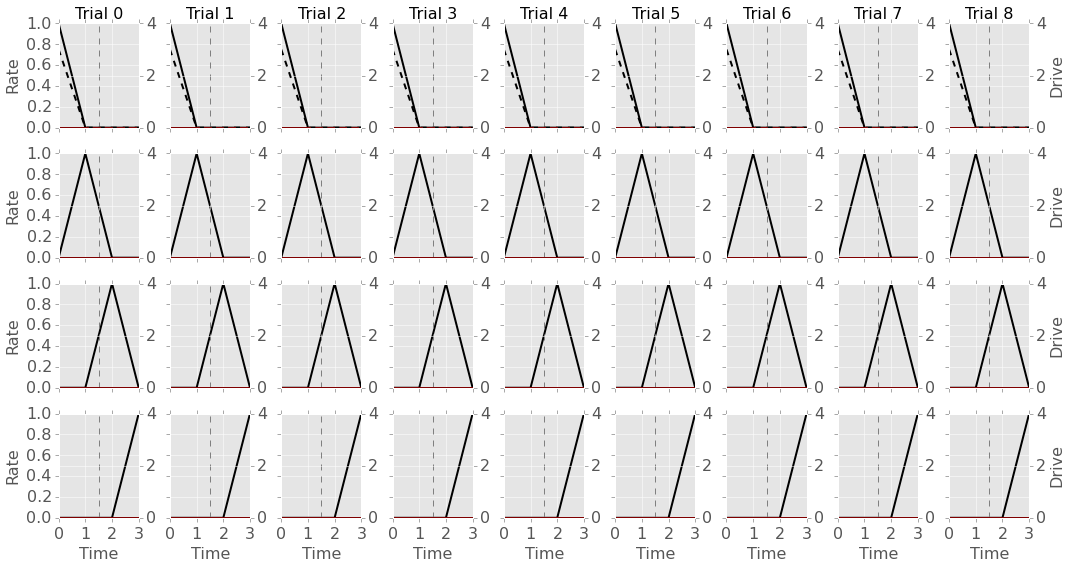

In [21]:
softmax_chains_replay.replay_weak_cxns_added(CONFIG)

In [22]:
CONFIG['N_TRIALS'] = 6
CONFIG['DRIVE_BY_COORDINATE'] = [
    [((1, chain_pos), 3) if chain_pos < 2 else ((0, chain_pos), 3) for chain_pos in range(4)] + 
    [((0, 0), 0), ((0, 0), 0), ((0, 0), 0), ((0, 0), 0)]
    for _ in range(6)
]

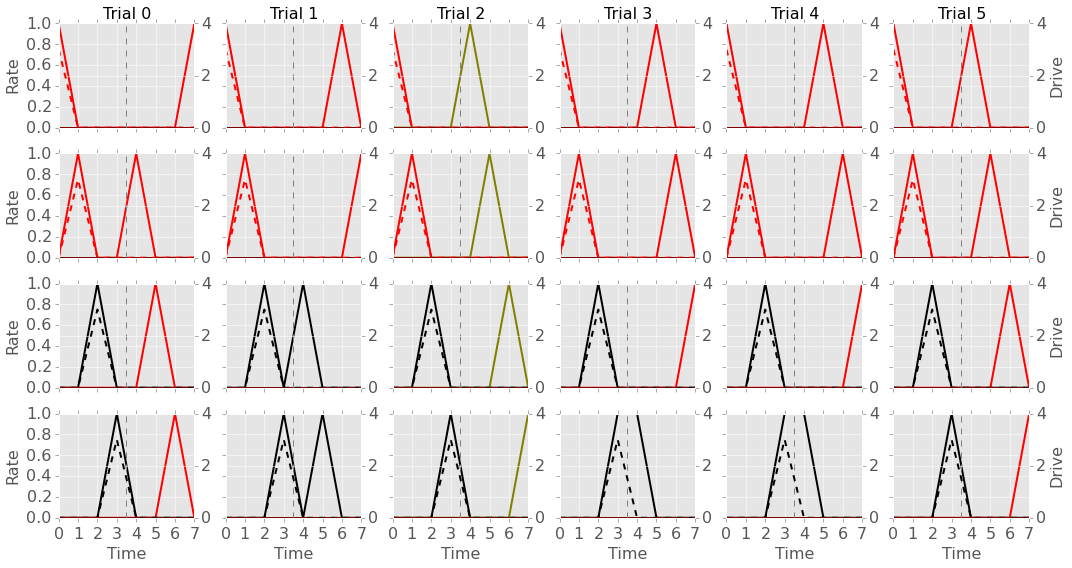

In [23]:
softmax_chains_replay.replay_weak_cxns_added(CONFIG)